In [1]:
import os
import json
import pandas as pd
from datetime import datetime, timezone
from pathlib import Path

from traffic.core import Traffic

from utils.process_audio import ATCFileMeta, AudioCatalog
from pydub import AudioSegment

****
# Helpers
****

In [2]:
def load_transcripts_json(path):
    with open(path) as f:
        data = json.load(f)
    # convert iso → datetime
    return [
        [(datetime.fromisoformat(ts), text) for ts, text in transcripts]
        for transcripts in data
    ]

def load_callsign_comms_json(path):
    with open(path) as f:
        data = json.load(f)
    # convert iso → datetime
    return {
        cs: [
            {
                **entry,
                "timestamp": datetime.fromisoformat(entry["timestamp"])
            }
            for entry in entries
        ]
        for cs, entries in data.items()
    }
    
def load_audio_catalog_from_json(path: str | Path,
                                    target_sr: int = 16000,
                                    mono: bool = True) -> AudioCatalog:
        """
        Reload a catalog from JSON (previously saved with only ATCFileMeta).
        Returns list of (ATCFileMeta, AudioSegment).
        """
        with open(path, "r") as f:
            data = json.load(f)

        catalog: AudioCatalog = []
        for entry in data:
            meta = ATCFileMeta(
                sector=entry["sector"],
                dt=datetime.fromisoformat(entry["dt"]).replace(tzinfo=timezone.utc),
                freq_hz=int(entry["freq_hz"]),
                freq_mhz=float(entry["freq_mhz"]),
                ext=entry["ext"],
                original_name=entry["original_name"],
                path=entry["path"],
            )

            # reload audio
            seg = AudioSegment.from_file(meta.path)
            if mono:
                seg = seg.set_channels(1)
            if target_sr:
                seg = seg.set_frame_rate(target_sr)

            catalog.append((meta, seg))

        # sort by timestamp just in case
        catalog.sort(key=lambda item: item[0].dt)
        return catalog

****
# Loading
****

### from 25/08 to 17/09

WARNING: NOT ALL DATES BECAUSE MISSING AUDIO

No audio: 05/09, 06/09, 07/09, 08/09 (partial), after 17/09 no audio in the recorded files

No adsb: 13/09 

In [3]:
output_dirs = ["20250825", "20250826", "20250827", "20250828", "20250829", "20250830", "20250831", 
               "20250901", "20250902", "20250903", "20250904", "20250909", "20250910", "20250911", 
               "20250912", "20250914", "20250915", "20250916", "20250917"]

In [4]:
from tqdm import tqdm

transcripts = {}
adsbs = {}
callsigns_coms = {}

for date in tqdm(output_dirs):
    transcripts[date] = load_transcripts_json(os.path.join("outputs", date, "transcripts.json"))
    adsbs[date] = Traffic.from_file(os.path.join("outputs", date, "adsb.parquet"))
    callsigns_coms[date] = pd.read_parquet(os.path.join("outputs", date, "callsign_comms.parquet"))
    


100%|██████████| 19/19 [00:23<00:00,  1.26s/it]


****
# Transcription performance
****

In [28]:
# AVG number of communications per day
# Callsign_coms contains all the transcripts only

import numpy as np

nb_com = []
for key, val in callsigns_coms.items():
    if len(transcripts[key]) < 24:
        print(f"WARNING: {key} not full day with only {len(transcripts[key])} hours")
        continue
    nb_com.append(len(val))
print(f"Avg number of communications: {np.mean(nb_com)}")
print(f"Med number of communications: {np.median(nb_com)}")
print(f"25th and 75th quantiles: {np.quantile(nb_com, 0.25)}, {np.quantile(nb_com, 0.75)}")

Avg number of communications: 5624.6
Med number of communications: 6035.0
25th and 75th quantiles: 4776.5, 6795.0


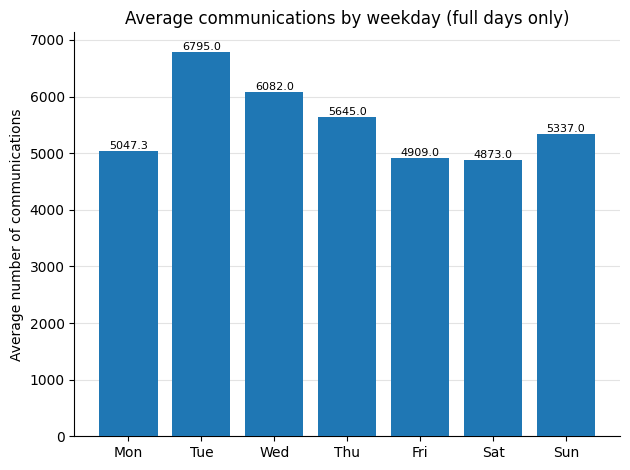

In [31]:
# AVG number of communication per weekday

from collections import defaultdict
import matplotlib.pyplot as plt

counts_by_weekday = defaultdict(list)  # key: 0=Mon ... 6=Sun

for key, val in callsigns_coms.items():
    # Skip partial days
    if len(transcripts[key]) < 24:
        continue
    
    dt = datetime.strptime(str(key), "%Y%m%d")
    wd = dt.weekday()  # 0=Mon ... 6=Sun
    counts_by_weekday[wd].append(len(val))

weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
avg_by_weekday = [
    np.mean(counts_by_weekday[w]) if counts_by_weekday[w] else 0
    for w in range(7)
]

fig, ax = plt.subplots()

ax.set_axisbelow(True)
ax.bar(weekday_labels, avg_by_weekday, edgecolor='none', zorder=3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linewidth=0.8, alpha=0.35)

ax.set_ylabel('Average number of communications')
ax.set_title('Average communications by weekday (full days only)')
for i, v in enumerate(avg_by_weekday):
    ax.text(i, v, f'{v:.1f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
counts_by_weekday # Not super meaningful 

defaultdict(list,
            {0: [6962, 6859, 1321],
             1: [6799, 6791],
             2: [6351, 7492, 4403],
             3: [5745, 6510, 4680],
             4: [4909],
             5: [4873],
             6: [6035, 4639]})

Overall average words/transcription: 10.17
         date  avg_words
0  2025-08-25  10.772910
1  2025-08-26   8.622886
2  2025-08-27   7.078255
3  2025-08-28   8.765361
4  2025-08-29   8.661234


/tmp/ipykernel_643515/978532146.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=[d.strftime('%Y-%m-%d') for d in order], showfliers=False)


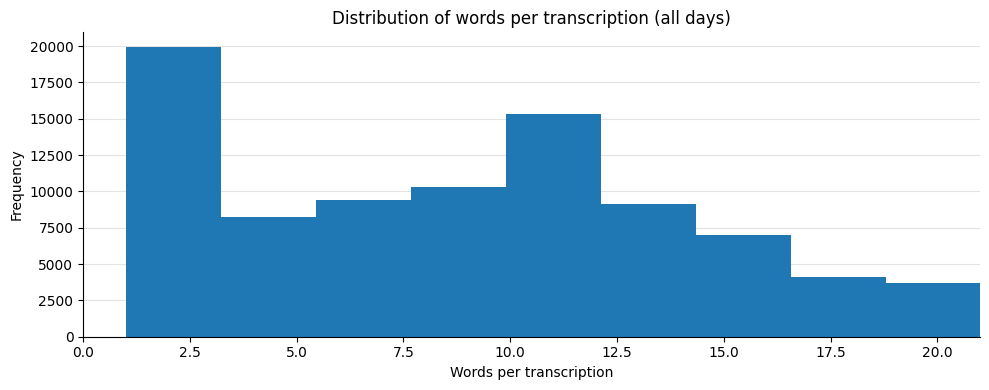

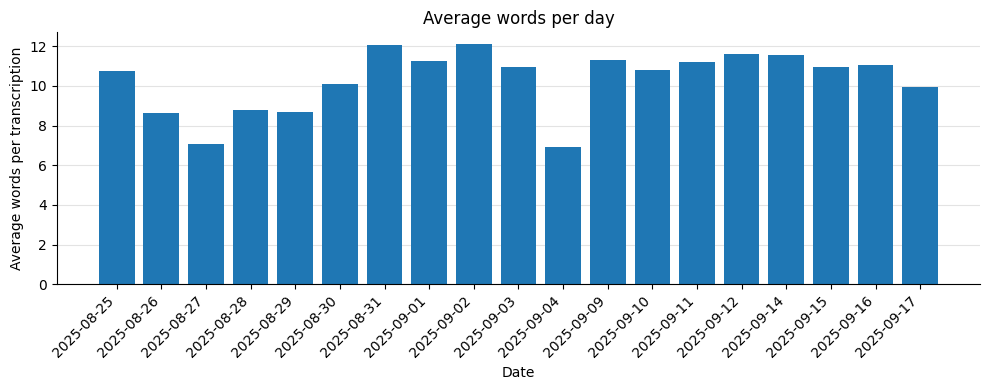

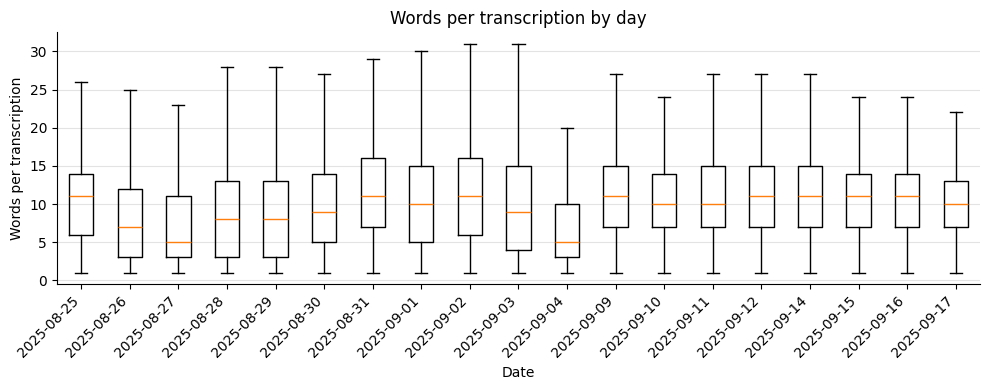

In [76]:
import pandas as pd 

frames = []
for date_key, df in callsigns_coms.items():
    wc = df['sentence'].fillna('').astype(str).str.split().map(len)
    frames.append(pd.DataFrame({
        'date': pd.to_datetime(str(date_key), format='%Y%m%d'),
        'word_count': wc.values
    }))

all_wc = pd.concat(frames, ignore_index=True)

overall_avg = all_wc['word_count'].mean()
avg_per_day = (
    all_wc
    .groupby(all_wc['date'].dt.date)['word_count']
    .mean()
    .rename('avg_words')
    .reset_index()
)

print(f"Overall average words/transcription: {overall_avg:.2f}")
print(avg_per_day.head())

# Overall distribution 
fig, ax = plt.subplots(figsize=(10,4))
ax.hist(all_wc['word_count'], bins=200)
ax.set_xlabel('Words per transcription')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of words per transcription (all days)')
ax.spines['top'].set_visible(False)
ax.set_xlim((0,21))
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.35)
ax.set_axisbelow(True)
plt.tight_layout()

# Per-day average
fig, ax = plt.subplots(figsize=(10,4))
x = avg_per_day['date'].astype(str)
y = avg_per_day['avg_words'].values
ax.bar(x, y)
ax.set_xlabel('Date')
ax.set_ylabel('Average words per transcription')
ax.set_title('Average words per day')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.35)
ax.set_axisbelow(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Per-day distribution
order = sorted(all_wc['date'].dt.date.unique())
data = [all_wc.loc[all_wc['date'].dt.date == d, 'word_count'] for d in order]

fig, ax = plt.subplots(figsize=(10,4))
ax.boxplot(data, labels=[d.strftime('%Y-%m-%d') for d in order], showfliers=False)
ax.set_xlabel('Date')
ax.set_ylabel('Words per transcription')
ax.set_title('Words per transcription by day')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.35)
ax.set_axisbelow(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [43]:
nb_flights = []
for key, val in adsbs.items():
    nb_flights.append(len(val))
print(f"Avg number of flights: {np.mean(nb_flights)}")
print(f"Med number of flights: {np.median(nb_flights)}")
print(f"25th and 75th flights: {np.quantile(nb_flights, 0.25)}, {np.quantile(nb_flights, 0.75)}")

Avg number of flights: 4661.526315789473
Med number of flights: 5258.0
25th and 75th flights: 5040.0, 5447.0


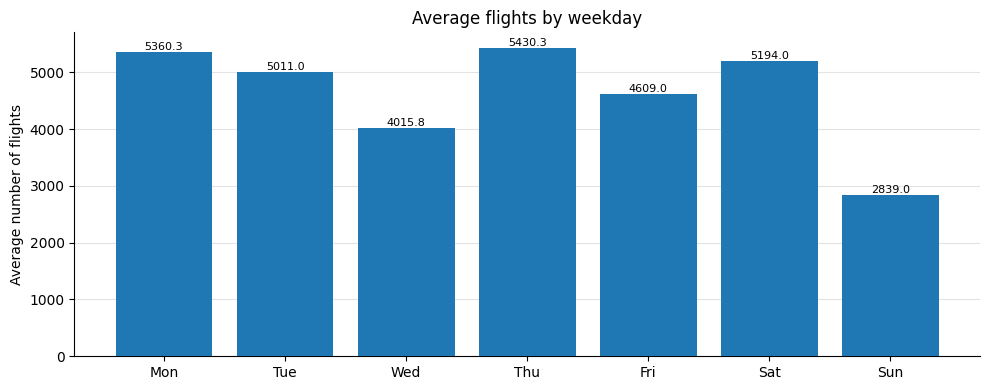

In [77]:
counts_by_weekday = defaultdict(list)  # key: 0=Mon ... 6=Sun

for key, val in adsbs.items():
    
    dt = datetime.strptime(str(key), "%Y%m%d")
    wd = dt.weekday()  # 0=Mon ... 6=Sun
    counts_by_weekday[wd].append(len(val))

weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
avg_by_weekday = [
    np.mean(counts_by_weekday[w]) if counts_by_weekday[w] else 0
    for w in range(7)
]

fig, ax = plt.subplots(figsize=(10,4))

ax.set_axisbelow(True)
ax.bar(weekday_labels, avg_by_weekday, edgecolor='none', zorder=3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linewidth=0.8, alpha=0.35)

ax.set_ylabel('Average number of flights')
ax.set_title('Average flights by weekday')
for i, v in enumerate(avg_by_weekday):
    ax.text(i, v, f'{v:.1f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [45]:
counts_by_weekday

defaultdict(list,
            {0: [5448, 5593, 5040],
             1: [5360, 5258, 5040, 4386],
             2: [5514, 5410, 61, 5078],
             3: [5584, 5446, 5261],
             4: [5127, 4091],
             5: [5194],
             6: [5604, 74]})

****
# Matching performance
****

In [13]:
import numpy as np
ner_matched = []

for key, val in callsigns_coms.items():
    ner_matched.append(val["detected"].notna().mean().item())
print(f"Avg NER callsign detection: {np.mean(ner_matched)}")
print(f"Med number NER detection: {np.median(ner_matched)}")
print(f"25th and 75th percentile of NER detection: {np.quantile(ner_matched, 0.25)}, {np.quantile(ner_matched, 0.75)}")


Avg NER callsign detection: 0.7872764993619815
Med number NER detection: 0.804142502071251
25th and 75th percentile of NER detection: 0.7563776037246941, 0.8298694118471566


In [58]:
matched_callsign = []

for key, val in callsigns_coms.items():
    matched_callsign.append(val["matched"].mean().item())
print(f"Avg number of match above 0.7: {np.mean(matched_callsign)}")
print(f"Med number of of match above 0.7: {np.median(matched_callsign)}")
print(f"25th and 75th percentile of match above 0.7: {np.quantile(matched_callsign, 0.25)}, {np.quantile(matched_callsign, 0.75)}")

Avg number of match above 0.7: 0.39835114873445543
Med number of of match above 0.7: 0.44087026161238657
25th and 75th percentile of match above 0.7: 0.3903603922492418, 0.474571280868218


In [60]:
matched_callsign_perfect = []

for key, val in callsigns_coms.items():
    matched_callsign_perfect.append((val["score"] == 1).mean())
print(f"Avg number of perfect match: {np.mean(matched_callsign_perfect)}")
print(f"Med number of perfect match: {np.median(matched_callsign_perfect)}")
print(f"25th and 75th percentiles perfect match: {np.quantile(matched_callsign_perfect, 0.25)}, {np.quantile(matched_callsign_perfect, 0.75)}")

Avg number of perfect match: 0.09000893766362708
Med number of perfect match: 0.10497157019973757
25th and 75th percentiles perfect match: 0.05889138810245511, 0.12631894821345224


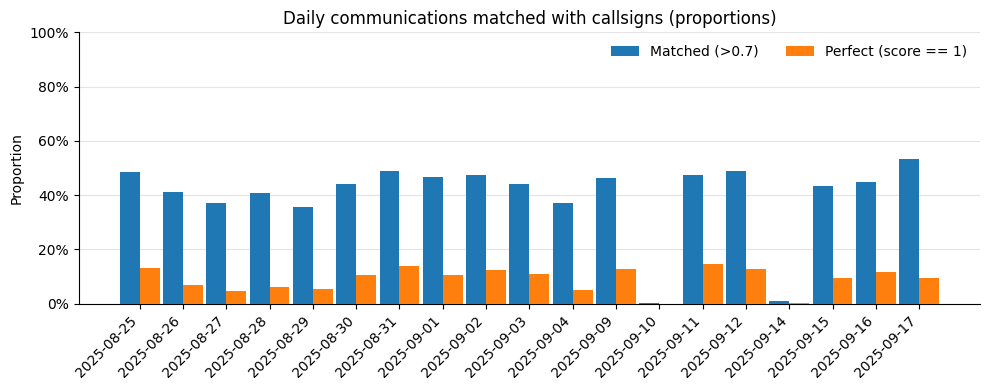

In [ ]:
from matplotlib.ticker import PercentFormatter

rows = []
for key, df in callsigns_coms.items():
    date = pd.to_datetime(str(key), format='%Y%m%d')
    matched_rate = df['matched'].astype(float).mean()      # proportion matched (>0.7)
    perfect_rate = (df['score'] == 1).mean()               # proportion perfect
    rows.append((date, matched_rate, perfect_rate))

daily = (pd.DataFrame(rows, columns=['date','matched_rate','perfect_rate'])
           .sort_values('date')
           .set_index('date'))

x = np.arange(len(daily))
width = 0.46

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(x - width/2, daily['matched_rate'].values, width, label='Matched (>0.7)', zorder=3)
ax.bar(x + width/2, daily['perfect_rate'].values, width, label='Perfect (score == 1)', zorder=3)

# Axis & labels
ax.set_ylabel('Proportion')
ax.set_title('Daily communications matched with callsigns')
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

# X ticks (reduce clutter if many days)
ax.set_xticks(x)
ax.set_xticklabels(daily.index.strftime('%Y-%m-%d'), rotation=45, ha='right')
if len(daily) > 14:
    step = max(1, len(daily)//12)
    for i, label in enumerate(ax.get_xticklabels()):
        label.set_visible(i % step == 0)

# Style: grid behind, remove top/right spines
ax.set_axisbelow(True)
ax.grid(axis='y', alpha=0.35)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(frameon=False, ncol=2)
plt.tight_layout()
plt.show()

In [61]:
match_score = []

for key, val in callsigns_coms.items():
    match_score.append(val["score"].mean())
print(f"Avg match score (above 0.7): {np.mean(match_score)}")
print(f"Med match score (above 0.7): {np.median(match_score)}")
print(f"25th and 75th percentiles match score (above 0.7): {np.quantile(match_score, 0.25)}, {np.quantile(match_score, 0.75)}")

Avg match score (above 0.7): 0.8505069493521441
Med match score (above 0.7): 0.853362831858407
25th and 75th percentiles match score (above 0.7): 0.8399369249494713, 0.8617498855838523


In [16]:
# Flip rate for consecutive matched rows -> proxy for conversation

mean_runs = []
flip_rates = []

for key, val in callsigns_coms.items():
    d = val.sort_values('timestamp').loc[val.matched, 'callsign']
    flips = (d != d.shift()).sum() - 1 if len(d) else 0
    runs = flips + 1 if len(d) else 0
    mean_run = len(d)/runs if runs>0 else 0
    flip_rate = flips/max(len(d)-1,1) if len(d)>1 else 0
    mean_runs.append(mean_run)
    flip_rates.append(flip_rate)

print(f"Avg mean run and flip rate: {np.mean(mean_runs)}, {np.mean(flip_rates)}")
print(f"Med mean run and flip rate: {np.median(mean_runs)}, {np.median(flip_rates)}")
print(f"25th and 75th percentiles mean run: {np.quantile(mean_runs, 0.25)}, {np.quantile(mean_runs, 0.75)}")
print(f"25th and 75th percentiles flip rate: {np.quantile(flip_rates, 0.25)}, {np.quantile(flip_rates, 0.75)}")

Avg mean run and flip rate: 1.2335878170343055, 0.8116061924696096
Med mean run and flip rate: 1.2363566487317448, 0.808768656716418
25th and 75th percentiles mean run: 1.1585984299591698, 1.296065471740873
25th and 75th percentiles flip rate: 0.7571439147172045, 0.8630828926822549


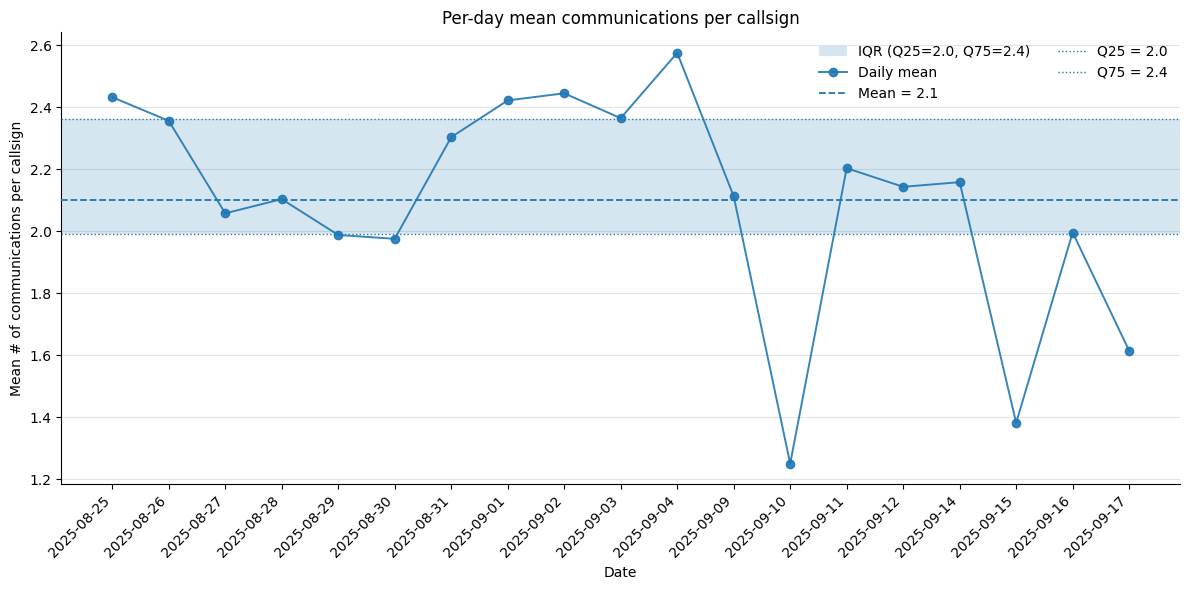

In [78]:
rows_per_callsign_mean = []
for date_key, df in callsigns_coms.items():
    m = df.groupby('callsign')['timestamp'].count().mean()
    rows_per_callsign_mean.append((pd.to_datetime(str(date_key), format='%Y%m%d'), m))

per_day = pd.DataFrame(rows_per_callsign_mean, columns=['date', 'mean_rows_per_callsign']).sort_values('date')
per_day.set_index('date', inplace=True)

y = per_day['mean_rows_per_callsign']
mean_val = y.mean()
q25, q75 = np.quantile(y, [0.25, 0.75])

x = np.arange(len(per_day))                                  # 0..N-1
labels = per_day.index.strftime('%Y-%m-%d')                  # tick labels

fig, ax = plt.subplots(figsize=(12,6))
ax.axhspan(q25, q75, alpha=0.18, label=f'IQR (Q25={q25:.1f}, Q75={q75:.1f})', zorder=1)
ax.plot(x, y.values, marker='o', linewidth=1.4, alpha=0.9, zorder=3, label='Daily mean')
ax.axhline(mean_val, linestyle='--', linewidth=1.3, zorder=4, label=f'Mean = {mean_val:.1f}')
ax.axhline(q25, linestyle=':', linewidth=1.0, zorder=4, label=f'Q25 = {q25:.1f}')
ax.axhline(q75, linestyle=':', linewidth=1.0, zorder=4, label=f'Q75 = {q75:.1f}')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlabel('Date')
ax.set_ylabel('Mean # of communications per callsign')
ax.set_title('Per-day mean communications per callsign')
ax.set_axisbelow(True); ax.grid(axis='y', alpha=0.35)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
handles, lab = ax.get_legend_handles_labels()
order = [lab.index(l) for l in [
    f'IQR (Q25={q25:.1f}, Q75={q75:.1f})', 'Daily mean',
    f'Mean = {mean_val:.1f}', f'Q25 = {q25:.1f}', f'Q75 = {q75:.1f}'
] if l in lab]
ax.legend([handles[i] for i in order], [lab[i] for i in order], frameon=False, ncol=2)

plt.tight_layout()
plt.show()

In [17]:
# Singleton rate -> Missed communications
singleton_rate = []

for key, val in callsigns_coms.items():
    counts = val.loc[val.matched].groupby('callsign').size()
    singleton_rate.append((counts==1).mean())
print(f"Avg singleton rate: {np.mean(singleton_rate)}")
print(f"Med singleton rate: {np.median(singleton_rate)}")
print(f"25th and 75th percentiles singleton rate: {np.quantile(singleton_rate, 0.25)}, {np.quantile(singleton_rate, 0.75)}")

Avg singleton rate: 0.531702826094982
Med singleton rate: 0.5017895490336435
25th and 75th percentiles singleton rate: 0.4819278860910623, 0.563027478900844


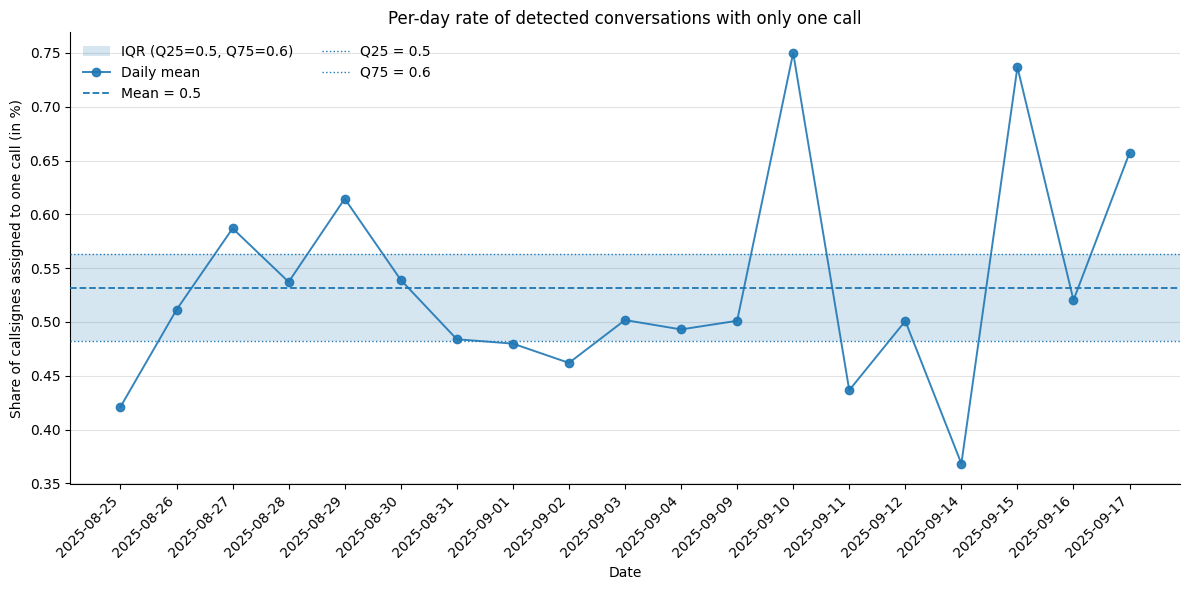

In [23]:
# Gaps between communications of a same conversation (same callsign)
import matplotlib.pyplot as plt

singleton_rate = []
for date_key, df in callsigns_coms.items():
    counts = df.loc[df.matched].groupby('callsign').size()
    singleton_rate.append((pd.to_datetime(str(date_key), format='%Y%m%d'), (counts==1).mean()))

per_day = pd.DataFrame(singleton_rate, columns=['date', 'singleton_rate']).sort_values('date')
per_day.set_index('date', inplace=True)

y = per_day['singleton_rate']
mean_val = y.mean()
q25, q75 = np.quantile(y, [0.25, 0.75])

x = np.arange(len(per_day))                                  # 0..N-1
labels = per_day.index.strftime('%Y-%m-%d')                  # tick labels

fig, ax = plt.subplots(figsize=(12,6))
ax.axhspan(q25, q75, alpha=0.18, label=f'IQR (Q25={q25:.1f}, Q75={q75:.1f})', zorder=1)
ax.plot(x, y.values, marker='o', linewidth=1.4, alpha=0.9, zorder=3, label='Daily mean')
ax.axhline(mean_val, linestyle='--', linewidth=1.3, zorder=4, label=f'Mean = {mean_val:.1f}')
ax.axhline(q25, linestyle=':', linewidth=1.0, zorder=4, label=f'Q25 = {q25:.1f}')
ax.axhline(q75, linestyle=':', linewidth=1.0, zorder=4, label=f'Q75 = {q75:.1f}')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlabel('Date')
ax.set_ylabel('Share of callsignes assigned to one call (in %)')
ax.set_title('Per-day rate of detected conversations with only one call')
ax.set_axisbelow(True); ax.grid(axis='y', alpha=0.35)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
handles, lab = ax.get_legend_handles_labels()
order = [lab.index(l) for l in [
    f'IQR (Q25={q25:.1f}, Q75={q75:.1f})', 'Daily mean',
    f'Mean = {mean_val:.1f}', f'Q25 = {q25:.1f}', f'Q75 = {q75:.1f}'
] if l in lab]
ax.legend([handles[i] for i in order], [lab[i] for i in order], frameon=False, ncol=2)

plt.tight_layout()
plt.show()

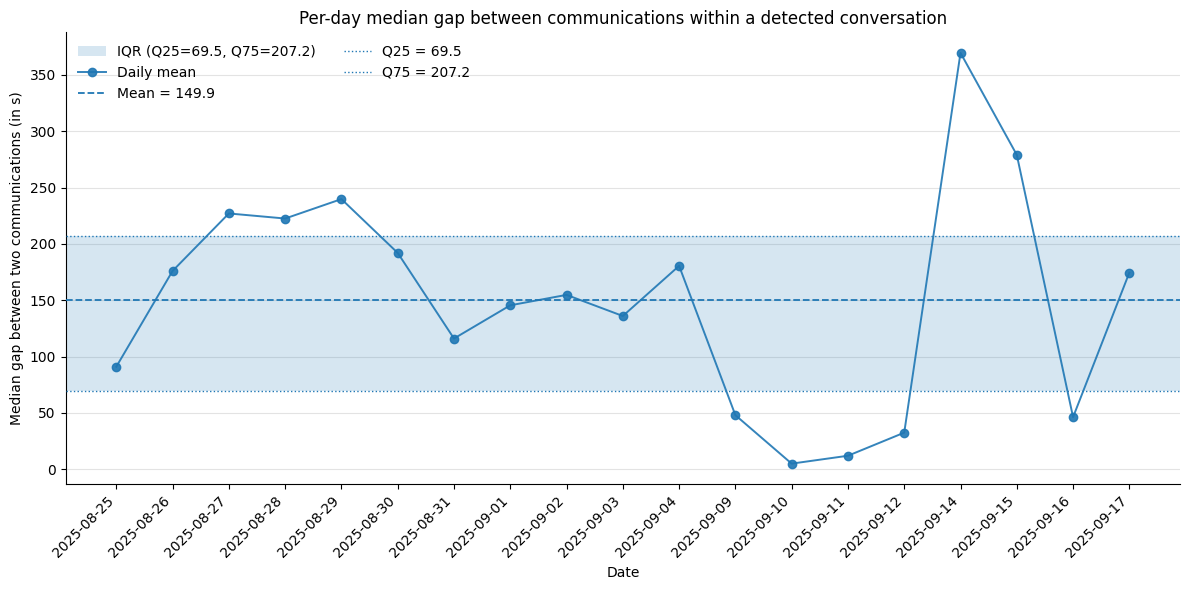

In [21]:
# Gaps between communications of a same conversation (same callsign)
import matplotlib.pyplot as plt
def gap_stats(df):
    out=[]
    for cs, g in df.loc[df.matched].groupby('callsign'):
        t = pd.to_datetime(g['timestamp']).sort_values().values
        if len(t)>1:
            gaps = np.diff(t).astype('timedelta64[s]').astype(int)
            out.append(np.median(gaps))
    return np.median(out) if out else np.nan

median_gap = []
for date_key, df in callsigns_coms.items():
    gap = gap_stats(df)
    median_gap.append((pd.to_datetime(str(date_key), format='%Y%m%d'), gap))

per_day = pd.DataFrame(median_gap, columns=['date', 'median_gap']).sort_values('date')
per_day.set_index('date', inplace=True)

y = per_day['median_gap']
mean_val = y.mean()
q25, q75 = np.quantile(y, [0.25, 0.75])

x = np.arange(len(per_day))                                  # 0..N-1
labels = per_day.index.strftime('%Y-%m-%d')                  # tick labels

fig, ax = plt.subplots(figsize=(12,6))
ax.axhspan(q25, q75, alpha=0.18, label=f'IQR (Q25={q25:.1f}, Q75={q75:.1f})', zorder=1)
ax.plot(x, y.values, marker='o', linewidth=1.4, alpha=0.9, zorder=3, label='Daily mean')
ax.axhline(mean_val, linestyle='--', linewidth=1.3, zorder=4, label=f'Mean = {mean_val:.1f}')
ax.axhline(q25, linestyle=':', linewidth=1.0, zorder=4, label=f'Q25 = {q25:.1f}')
ax.axhline(q75, linestyle=':', linewidth=1.0, zorder=4, label=f'Q75 = {q75:.1f}')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlabel('Date')
ax.set_ylabel('Median gap between two communications (in s)')
ax.set_title('Per-day median gap between communications within a detected conversation')
ax.set_axisbelow(True); ax.grid(axis='y', alpha=0.35)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
handles, lab = ax.get_legend_handles_labels()
order = [lab.index(l) for l in [
    f'IQR (Q25={q25:.1f}, Q75={q75:.1f})', 'Daily mean',
    f'Mean = {mean_val:.1f}', f'Q25 = {q25:.1f}', f'Q75 = {q75:.1f}'
] if l in lab]
ax.legend([handles[i] for i in order], [lab[i] for i in order], frameon=False, ncol=2)

plt.tight_layout()
plt.show()